# Convolutional Neural Network - part B

In this notebook we will look a very quickl look at what convolutional layers learn

Goal of this lab is to:

* Visualize and understand what convolutional layer learns

# Optional project - reproducibility challenge

You are welcome to work on it during the lab if you have finished the exercises. https://www.cs.mcgill.ca/~jpineau/ICLR2018-ReproducibilityChallenge.html

* Counts as 4 points (~ should be approximately worth of exercises from 2 labs)
* Pick an ICLR paper and then consult the choice
* Deadline for submitting the report is 20.06.2018, 23:59:59.
* Don't pick papers submitted by GMUM :)

# Whiteboard exercises

( + Any exercise from the previous labs )

* (0.5) What is the most common way to apply batch normalization to convolutional layer output? Provide an explanation behind it. Reference: https://arxiv.org/pdf/1502.03167v3.pdf.

* (0.5) Look up instance normalization, a variant of batch normalization. Explain: (i) how it works, (ii) when and why it might be preferable to batch normalization.

* (0.5) Should we apply batch normalization before or after Dense layer? Provide an explanation. Reference: https://arxiv.org/pdf/1502.03167v3.pdf.

# Setup

In [1]:
# Boilerplate code to get started

%load_ext autoreload
%autoreload 
%matplotlib inline

import json
import matplotlib as mpl
from src import fmnist_utils
from src.fmnist_utils import *

from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt

def plot(H):
    plt.title(max(H['test_acc']))
    plt.plot(H['acc'], label="acc")
    plt.plot(H['test_acc'], label="test_acc")
    plt.legend()

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (7, 7)
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12

(x_train, y_train), (x_test, y_test) = fmnist_utils.get_data(which="mnist")

x_train_4d = x_train.view(-1, 1, 28, 28)
x_test_4d = x_test.view(-1, 1, 28, 28)

/home/kg/miniconda3/envs/nn2018/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Exercise 1: Convolution vs FC on FMNIST

* Fill out blanks in the code
* Train an MLP and a ConvNet for the supplied hyperparameters. Which one works better in terms of generalization?

In [2]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [3]:
def build_conv(input_dim, output_dim, n_filters=32, maxpool=4, hidden_dims=[32], dropout=0.0):
    model = torch.nn.Sequential()
    
    P = 0
    
    # Convolution part
    model.add_module("conv2d", torch.nn.Conv2d(input_dim[0], n_filters, kernel_size=5, padding=P))
    model.add_module("relu", torch.nn.ReLU()) 
    model.add_module("maxpool", torch.nn.MaxPool2d(maxpool))
    model.add_module("dropout", torch.nn.Dropout2d(dropout))
    model.add_module("flatten", Flatten()) # Add flattening from 4d -> 2d. 
    
    W = input_dim[1]+ 2*P - 5 + 1
    H = input_dim[2] + 2*P - 5 + 1
    previous_dim = int(n_filters * ((W - maxpool) / maxpool + 1) * ((H - maxpool) / maxpool + 1))
    
    # Classifier
    for id, D in enumerate(hidden_dims):
        model.add_module("linear_{}".format(id), torch.nn.Linear(previous_dim, D, bias=True))
        model.add_module("nonlinearity_{}".format(id), torch.nn.ReLU())
        previous_dim = D
    model.add_module("final_layer", torch.nn.Linear(D, output_dim, bias=True))
    return model

100%|██████████| 50/50 [00:31<00:00,  1.66it/s]


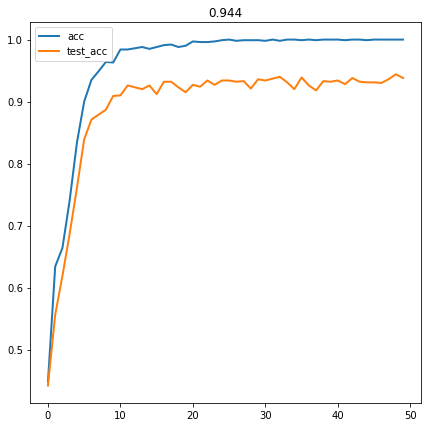

In [4]:
## Starting code for training a ConvNet.
input_dim = (1, 28, 28)

model = build_conv(input_dim, 10, n_filters=32, dropout=0.5)

loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

H = train(loss=loss, model=model, x_train=x_train_4d, y_train=y_train,
          x_test=x_test_4d, y_test=y_test,
          optim=optimizer, batch_size=128, n_epochs=50)

plot(H)

100%|██████████| 100/100 [00:08<00:00, 12.07it/s]


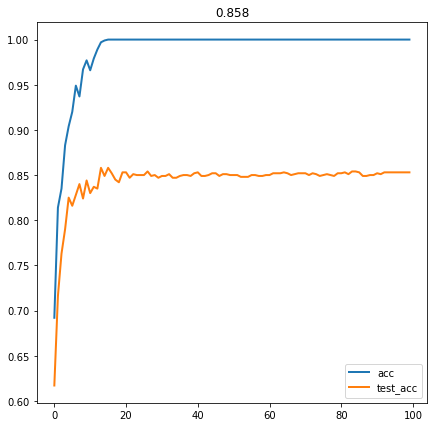

In [5]:
## Starting code for training a MLP.

model = build_mlp(784, 10)
loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
H_mlp = train(loss=loss, model=model, x_train=x_train, y_train=y_train,
          x_test=x_test, y_test=y_test, optim=optimizer, batch_size=128, n_epochs=100)

plot(H_mlp)

The CNN does better, much smaller gap between train/test acc.

# Exercise 2: examine filters

1. Plot filters from *best validation epoch* of the model in exercise 1. Please save them to file "9b_1.png".

2. Plot filter from different epochs. How are they changing? In which epochs do the filters stabilize? Please save your answer to "9b_2.txt"

In [6]:
def train_with_weights(model, loss, optim, 
          x_train, y_train, x_test, y_test, batch_size=100, n_epochs=10):
    """
    Trains given model on the FashionMNIST dataset.
    
    Returns
    -------
    history: dict
        History containing 'acc' and 'test_acc' keys.
    """
    torch.manual_seed(42) 
    n_examples = len(x_train)
    history = {"acc": [], "test_acc": [],"conv2d.weight": []}
    for i in tqdm.tqdm(range(n_epochs), total=n_epochs):
        
        # Ugly way to shuffle dataset
        ids = np.random.choice(len(x_train), len(x_train), replace=False)
        x_train = torch.from_numpy(x_train.numpy()[ids])
        y_train = torch.from_numpy(y_train.numpy()[ids])
        
        model.train()
        cost = 0.
        num_batches = n_examples // batch_size
        for k in range(num_batches):
            start, end = k * batch_size, (k + 1) * batch_size
            cost += step(model, loss, optim, x_train[start:end], y_train[start:end])
        
        history['conv2d.weight'].append(model.state_dict()['conv2d.weight'].clone())
        
        model.eval()
        predY = predict(model, x_test)
        test_acc = np.mean(predY == y_test.numpy())
        history['test_acc'].append(test_acc)
 
        # Usually it is computed from per batch averages, but I compute
        # here using the whole train set to reduce level of noise in the learning curves
        predY = predict(model, x_train)
        train_acc = np.mean(predY == y_train.numpy())
        history['acc'].append(train_acc)
        
    return history

100%|██████████| 50/50 [00:29<00:00,  1.65it/s]


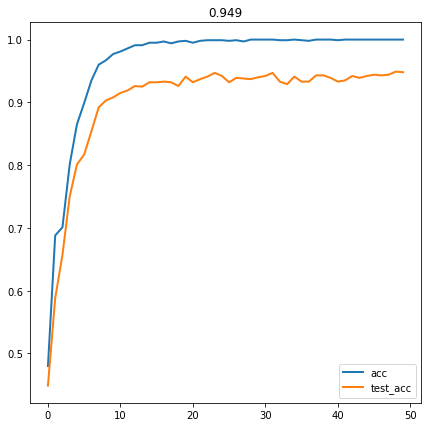

In [21]:
## Starting code for training a ConvNet.
input_dim = (1, 28, 28)

model = build_conv(input_dim, 10, n_filters=32, dropout=0.5)

loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

H = train_with_weights(loss=loss, model=model, x_train=x_train_4d, y_train=y_train,
          x_test=x_test_4d, y_test=y_test,
          optim=optimizer, batch_size=128, n_epochs=50)

plot(H)

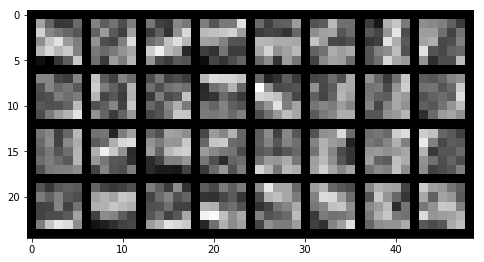

In [22]:
def vistensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    '''
    vistensor: visuzlization tensor
        @ch: visualization channel 
        @allkernels: visualization all tensores
    ''' 
    
    n, c, w, h = tensor.shape
    if allkernels: 
        tensor = tensor.view(n * c, -1, w, h )
    elif c != 3:
        tensor = tensor[:, ch, :, :].unsqueeze(dim=1)
        
    rows = np.min((tensor.shape[0]//nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

best_val_id = np.argmax(H['test_acc'])
filters = H['conv2d.weight'][best_val_id] # Get Torch Tensor corresponding to filters from the best validation point in training
vistensor(filters, ch=0, allkernels=True)
plt.savefig("9b_1.png")

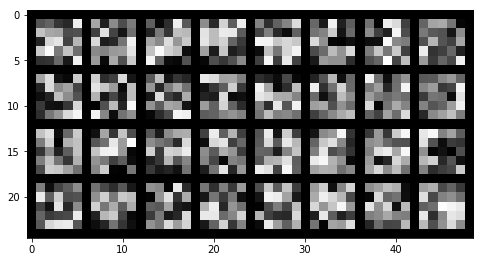

In [23]:
filters = H['conv2d.weight'][0]
vistensor(filters, ch=0, allkernels=True)

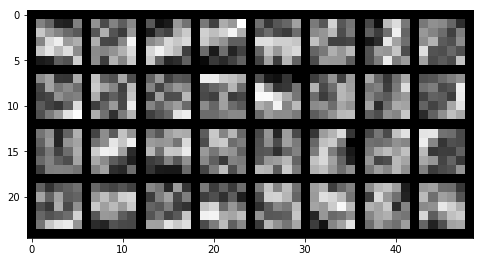

In [24]:
filters = H['conv2d.weight'][5]
vistensor(filters, ch=0, allkernels=True)

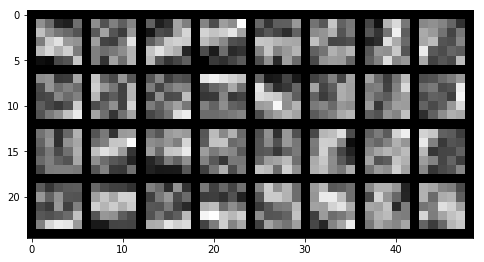

In [25]:
filters = H['conv2d.weight'][10]
vistensor(filters, ch=0, allkernels=True)

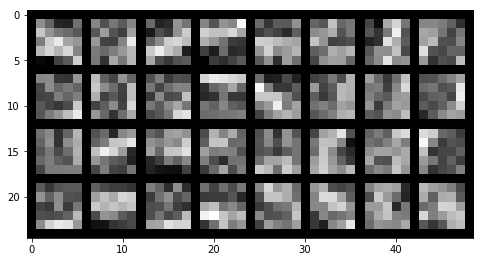

In [26]:
filters = H['conv2d.weight'][15]
vistensor(filters, ch=0, allkernels=True)

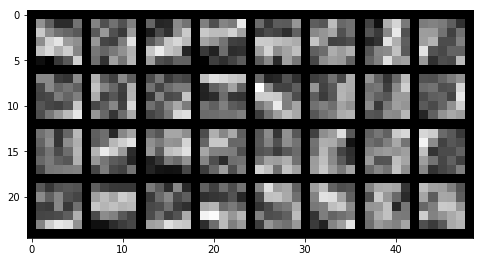

In [27]:
filters = H['conv2d.weight'][20]
vistensor(filters, ch=0, allkernels=True)

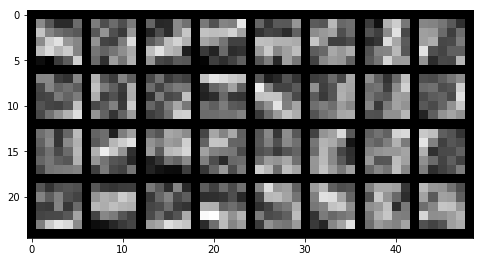

In [28]:
filters = H['conv2d.weight'][25]
vistensor(filters, ch=0, allkernels=True)

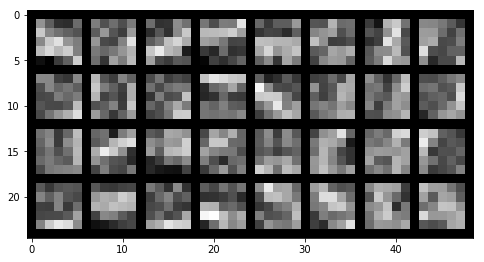

In [29]:
filters = H['conv2d.weight'][30]
vistensor(filters, ch=0, allkernels=True)

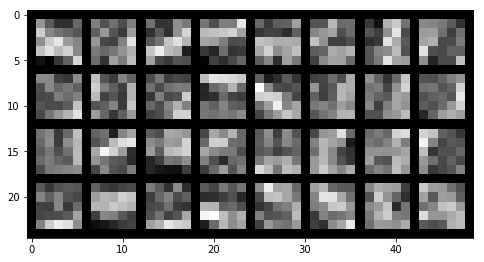

In [30]:
filters = H['conv2d.weight'][35]
vistensor(filters, ch=0, allkernels=True)

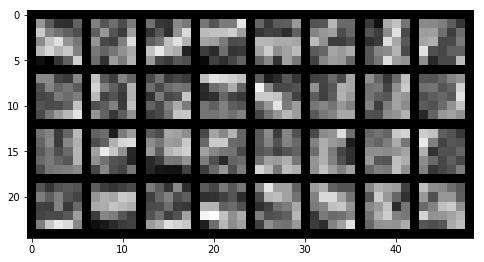

In [31]:
filters = H['conv2d.weight'][40]
vistensor(filters, ch=0, allkernels=True)

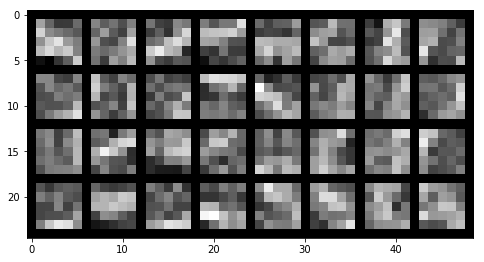

In [32]:
filters = H['conv2d.weight'][45]
vistensor(filters, ch=0, allkernels=True)

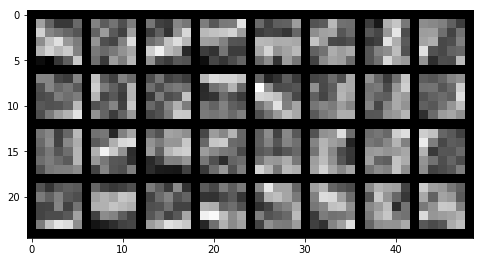

In [33]:
filters = H['conv2d.weight'][49]
vistensor(filters, ch=0, allkernels=True)

In [34]:
with open("9b_2.txt", "w") as text_file:
    print("The filters start out random and afterwards begin exhibiting some edge-detection (and similar) capabilities. They stabilize pretty quick, around the  5-10th epoch.", file=text_file)